In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
# create datasets
def generate_in_distribution_data(n, mu, sigma, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = mu
    mu_0 = -mu_1
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, sigma, pi_out, delta):
    n_1 = int(n*pi_out)
    n_0 = int(n*(1-pi_out))
    mu_1 = mu + delta
    mu_0 = -mu + delta
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

### Simulation Study

In [4]:
def compute_decision_rule(X_in, Y_in, X_out, Y_out, alpha):

    X_in_0 = X_in[Y_in == 0]
    X_in_0_bar = np.mean(X_in_0)

    X_in_1 = X_in[Y_in == 1]
    X_in_1_bar = np.mean(X_in_1)

    X_out_0 = X_out[Y_out == 0]
    X_out_0_bar = np.mean(X_out_0)

    X_out_1 = X_out[Y_out == 1]
    X_out_1_bar = np.mean(X_out_1)

    # estimate threshold
    c = (1-alpha)*(X_in_1_bar + X_in_0_bar)/2 + (alpha)*(X_out_1_bar + X_out_0_bar)/2
    
    return c

def compute_empirical_risk(X, Y, c):
    Y_pred = (X > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    delta = 0.8,
    alpha_range=np.arange(0, 1.2, 0.2),
    m_sizes = np.arange(0, 40, 2),
    reps = 1000
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, sigma, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, sigma, pi_in)
            
            for alpha in alpha_range:
                X_out, Y_out = generate_out_distribution_data(m, mu, sigma, pi_out, delta)
                c = compute_decision_rule(X_in, Y_in, X_out, Y_out, alpha)
                df.at[i, str(alpha)] = 1-compute_empirical_risk(X_test, y_test, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Alpha', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Accuracy")
    ax.set_xlabel(r"$m, n = {}$".format(n))
    # ax.set_xlim([0, 100])
    return df

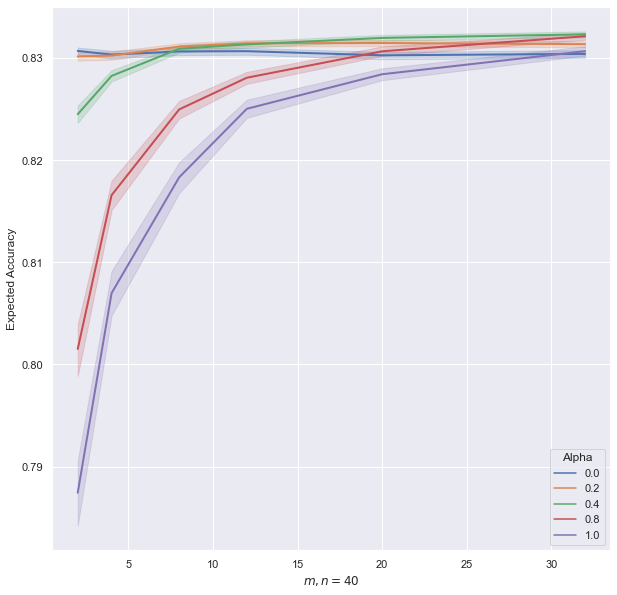

In [10]:
df = run_simulation(
    n = 40,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    delta = 0.1,
    alpha_range=[0.0, 0.2, 0.4, 0.8, 1.0],
    m_sizes = [2, 4, 8, 12, 20, 32],
    reps = 1000
)

### Theoretical Investigation

Let $D_{in} : \{ X_i, Y_i \}_{i=1}^n \stackrel{iid}{\sim} \mathcal{P}_t$ and $D_{out} : \{ X_i, Y_i \}_{i=1}^m \stackrel{iid}{\sim} \mathcal{P}_o$, where $\mathcal{P}_o$ is characterised by $X|Y=y \sim \mathcal{N}(\mu_0 - (-1)^y, 1), \; Y \sim \text{Bern}(0.5)$ and $\mathcal{P}_o$ is characterised by  $X|Y=y \sim \mathcal{N}(\mu_0 + \Delta - (-1)^y, 1), \; Y \sim \text{Bern}(0.5)$. We are interested in the following decision rule:
$$
\begin{equation}
        h(x) = 
        \begin{cases}
            1 & x > \alpha \hat{h}_{out} + (1-\alpha) \hat{h}_{in} \\
            0 & \text{otherwise}
        \end{cases}
\end{equation}
$$
where, 
$$ \hat{h}_{in} = \frac{1}{n} \sum_{i=1}^{n} (X_i + (-1)^{Y_i}) $$
$$ \hat{h}_{out} = \frac{1}{m} \sum_{j=1}^{m} (X_j + (-1)^{Y_j}) $$

It can be shown that the expected value and variance of $\hat{h} = \alpha \hat{h}_{out} + (1-\alpha) \hat{h}_{in}$ is given by (assuming $\mu_0 = 0$),

$$ \mu_h = \mathbb{E}[\hat{h}] = \alpha \Delta $$
$$ \sigma_h^2 = \text{Var}(\hat{h}) = 3 \bigg[ \frac{\alpha^2}{m} + \frac{(1-\alpha)^2}{n} \bigg] $$

The expected target risk is given by,

$$
\begin{equation}
\mathcal{E}_t(h) = \frac{1}{2}\bigg[ 1 + \Phi \bigg( \frac{\mu_h - 1}{\sqrt{1 + \sigma_h^2}} \bigg)  - \Phi \bigg( \frac{\mu_h + 1}{\sqrt{1 + \sigma_h^2}} \bigg)\bigg]
\end{equation}
$$

In [11]:
def expected_risk(n, m, delta, alpha):
    mu_h = alpha*delta
    sigma_h = np.sqrt(3 * (alpha**2/m + (1-alpha)**2/n))
    risk = 0.5*(1 + norm.cdf((mu_h - 1)/(np.sqrt(1 + sigma_h**2))) - norm.cdf((mu_h + 1)/(np.sqrt(1 + sigma_h**2))))
    return risk

Text(0.5, 0, '$m/n, n=40$')

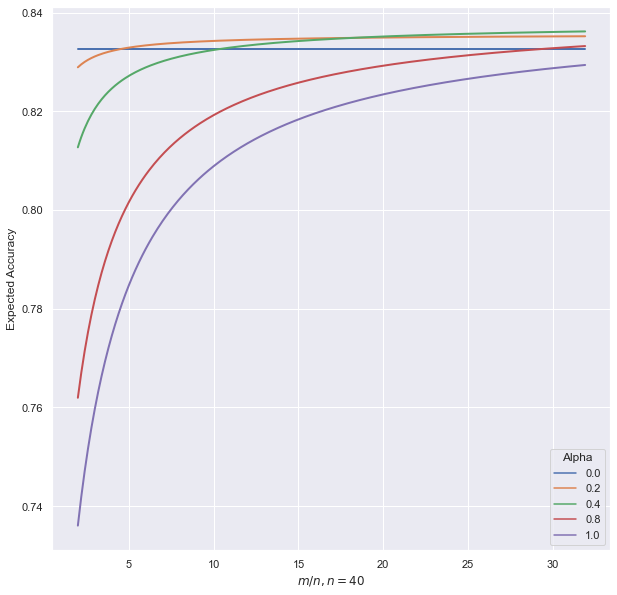

In [15]:
n = 40
m_sizes = np.arange(2, 32, 0.1)
delta = 0.1
alpha_range=[0.0, 0.2, 0.4, 0.8, 1.0]

i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m
    for alpha in alpha_range:
        df.at[i, str(alpha)] = 1-expected_risk(n, m, delta, alpha)
    i+=1

dfm = df.melt(['m'], var_name='Alpha', value_name='Risk')
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel("Expected Accuracy")
ax.set_xlabel(r"$m/n, n={}$".format(n))
# ax.set_xlim([0, 100])
